In [2]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import seaborn as sns
from cap_functs import rmse, mae, median_error, find_neigh_cnt, find_cnts_per_cat, compile_model_data
from cap_functs import percent_within_x, print_percents, print_percents_log, convert_mp_vals

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KDTree
from sklearn.utils import shuffle
from sklearn.metrics import median_absolute_error

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

Load geospatial datasets. Choose date range of crime and 311 data. 

In [2]:
rec_311_dt = pd.read_pickle('../ga_project_data/rec_311_dt')
print max(rec_311_dt.Opened)
rec_15up = rec_311_dt[rec_311_dt.Opened >= datetime.datetime(2015, 1, 1)]
rec_15up = rec_15up[rec_15up.Point.notnull()]
rec_15up['latitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[0])
rec_15up['longitude'] = rec_15up.Point.apply(lambda x: map(float, x.strip('()').split(', '))[1])
del rec_311_dt

2016-08-11 00:57:07


In [3]:
short_311_cats = ['Street and Sidewalk Cleaning', 'Damaged Property', 'SFHA Requests', 
                  'Street Defects', 'Sidewalk or Curb', 'Color Curb', 'Graffiti']

In [4]:
crimes_sf_dt = pd.read_pickle('../ga_project_data/crimes_sf_dt')

crime_15up = crimes_sf_dt[crimes_sf_dt.Date >= datetime.datetime(2015, 1, 1)]
crime_15up = crime_15up.rename(columns={'X': 'longitude', 'Y': 'latitude'})
del crimes_sf_dt

In [5]:
short_crime_cats = ['LARCENY/THEFT', 'VEHICLE THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 
                    'BURGLARY', 'ROBBERY', 'LOITERING', 'NON-CRIMINAL', 'WEAPON LAWS']

In [6]:
park_reg_pts = pd.DataFrame(gpd.read_file('./map_data/park_reg_pts/park_reg_pts.shp'))
park_reg_pts['geometry'] = park_reg_pts.geometry.apply(str, convert_dtype=str)
park_reg_pts = convert_mp_vals(df=park_reg_pts, column='geometry')
park_reg_pts = park_reg_pts[np.random.choice(park_reg_pts.shape[0], 
                                             len(park_reg_pts), replace=False), :]

In [7]:
ldn_76 = pd.read_pickle('ldn_76')
ldn_74 = pd.read_pickle('ldn_74')
ldn_72 = pd.read_pickle('ldn_72')
ldn_70 = pd.read_pickle('ldn_70')
ldn_66 = pd.read_pickle('ldn_66')

Load Airbnb dataset with census tract info added (median income and % below poverty line).

In [2]:
#bnb_list_full = pd.read_pickle('./bnb_list_full')
bnb_list_test = pd.read_pickle('./bnb_list_full_geo')
#bnb_list_test = pd.DataFrame(bnb_list_test)
bnb_list_test = bnb_list_test[bnb_list_test.reviews_per_month > 0.2]
bnb_list_test = shuffle(bnb_list_test, random_state=1000)
bnb_list_test.shape

(5187, 93)

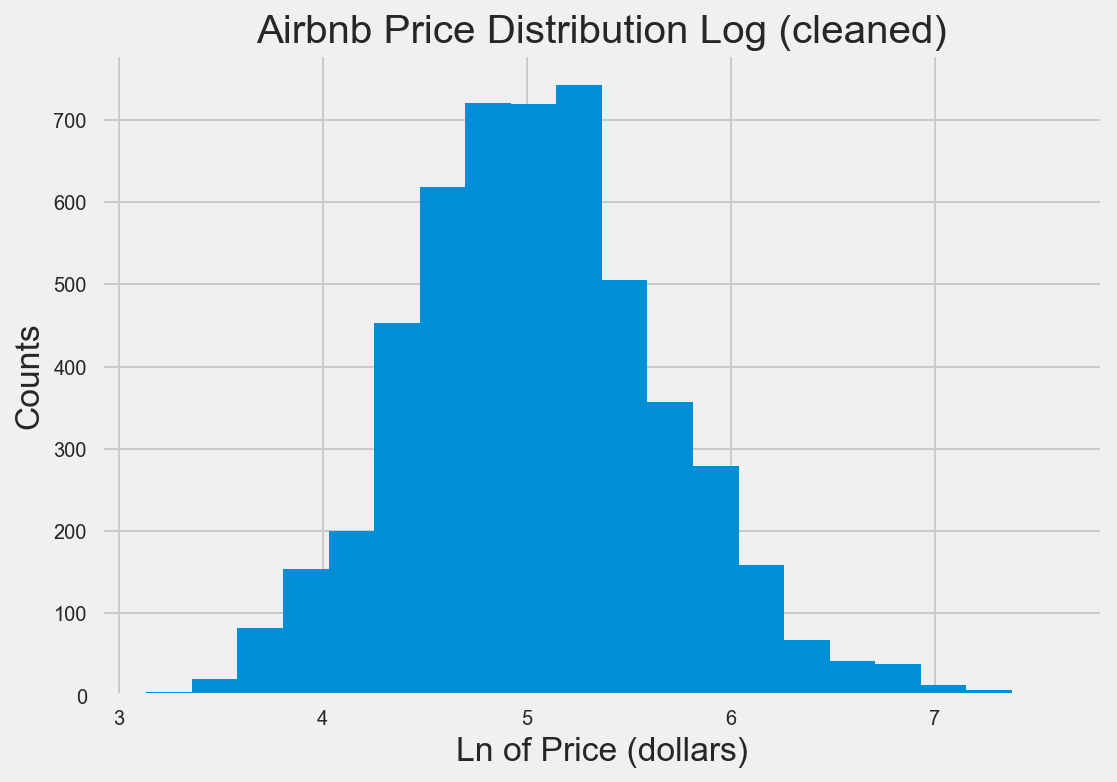

In [45]:
bnb_list_test.price.apply(lambda x: np.log1p(x)).hist(bins=20)
plt.title('Airbnb Price Distribution Log (cleaned)')
plt.xlabel('Ln of Price (dollars)')
plt.ylabel('Counts')
plt.savefig('Airbnb_price_dist_cleaned_log.pdf', facecolor='w')
plt.show();

Set desired search radius lengths for every category.

In [84]:
bnb_list_test = compile_model_data('crime and 311', bnb_list_test, short_311_cats, 
                                   short_crime_cats, crime_15up, rec_15up, 
                                   r_crime=0.004, r_311=0.004)


In [85]:
bnb_list_test = find_neigh_cnt('park_reg_pts', park_reg_pts, bnb_list_test, r=0.004)


In [ ]:
bnb_list_test = find_neigh_cnt('ldn_76', ldn_76, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_74', ldn_74, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_72', ldn_72, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_70', ldn_70, bnb_list_test, r=0.0012)
bnb_list_test = find_neigh_cnt('ldn_66', ldn_66, bnb_list_test, r=0.0012)

In [104]:
comments_tfidf = pd.read_pickle('comments_tfidf')
reviews_sentim = pd.read_pickle('review_sentiments')
#bnb_list_test = bnb_list_test.merge(reviews_sentim, how='left', left_on='id', right_on='listing_id')
#bnb_list_test = bnb_list_test.merge(comments_tfidf, how='left', left_on='id', right_on='listing_id')
bnb_list_test


,id_x,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities_x,price,...,welcoming,went,wifi,work,worked,youre,neg,neu,pos,compound
0,11826847,2.0,37.790072,-122.415288,2,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",69.0,...,0.080372,0.000000,0.000000,0.000000,0.000000,0.000000,0.024,0.616,0.361,1.0000
1,7065694,1.0,37.738057,-122.506229,5,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",350.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022,0.685,0.292,0.9991
2,5444754,5.0,37.758121,-122.418073,2,1.5,1.0,1.0,"{Internet,Kitchen,""Elevator in Building"",Heati...",105.0,...,0.036193,0.042946,0.095083,0.081733,0.049006,0.000000,0.017,0.691,0.292,0.9999
3,12151345,4.0,37.780958,-122.389284,4,1.5,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",249.0,...,0.000000,0.000000,0.000000,0.138291,0.000000,0.000000,0.015,0.718,0.268,0.9997
4,5616609,1.0,37.740353,-122.453188,2,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",119.0,...,0.064683,0.019188,0.000000,0.036517,0.021896,0.000000,0.019,0.682,0.298,1.0000
5,7902889,2.0,37.785940,-122.394088,1,1.0,1.0,2.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Elev...",90.0,...,0.093681,0.027790,0.000000,0.079333,0.031712,0.000000,0.027,0.641,0.332,1.0000
6,1768861,3.0,37.753174,-122.443759,4,2.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",599.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048,0.689,0.263,0.9954
7,5632275,1.0,37.754373,-122.429536,2,1.0,1.0,1.0,"{TV,""Wireless Internet"",Kitchen,""Pets Allowed""...",165.0,...,0.068088,0.053862,0.000000,0.025627,0.000000,0.000000,0.013,0.656,0.331,1.0000
8,4106442,1.0,37.754515,-122.416497,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",200.0,...,0.113860,0.033776,0.000000,0.016070,0.000000,0.053692,0.022,0.684,0.294,1.0000
9,1269738,1.0,37.760553,-122.420868,3,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",120.0,...,0.045477,0.107925,0.059736,0.000000,0.061577,0.114375,0.035,0.652,0.313,0.9999


In [14]:
# Feature engineer a column that is the product of all of the noise levels
# bnb_list_test['noise_mult'] = np.log((np.array(bnb_list_test.ldn_66.values)+1)*(np.array(bnb_list_test.ldn_70.values)+1)*\
#                               (np.array(bnb_list_test.ldn_72.values)+1)*(np.array(bnb_list_test.ldn_74.values)+1)*\
#                               (np.array(bnb_list_test.ldn_76.values)+1))

In [184]:
comments_tfidf

,listing_id,able,absolutely,access,accommodating,accurate,airbnb,airbnb experience,amazing,amenities,...,welcoming,went,wifi,work,worked,youre,neg,neu,pos,compound
0,958,0.015324,0.046690,0.072350,0.013397,0.000000,0.080592,0.000000,0.038261,0.033421,...,0.040799,0.048412,0.035728,0.030711,0.018414,0.000000,0.027,0.679,0.295,1.0000
1,5193,0.060574,0.049215,0.085796,0.010591,0.037164,0.063713,0.014978,0.141155,0.052843,...,0.026878,0.057409,0.063551,0.030349,0.036394,0.027040,0.024,0.664,0.312,1.0000
2,5841,0.000000,0.024325,0.022616,0.062818,0.000000,0.062980,0.059223,0.039866,0.026118,...,0.021256,0.000000,0.000000,0.048000,0.000000,0.133645,0.030,0.675,0.295,1.0000
3,5858,0.023979,0.036531,0.011321,0.062893,0.000000,0.115602,0.088941,0.069849,0.000000,...,0.159607,0.025252,0.013977,0.024029,0.000000,0.000000,0.012,0.619,0.369,1.0000
4,7918,0.067174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073252,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049,0.682,0.269,0.9996
5,8014,0.036283,0.000000,0.000000,0.015860,0.000000,0.079506,0.000000,0.030196,0.000000,...,0.032199,0.095519,0.042296,0.018179,0.021799,0.000000,0.024,0.698,0.278,1.0000
6,8142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049,0.691,0.260,0.9969
7,8339,0.102440,0.104039,0.024183,0.022390,0.031425,0.000000,0.000000,0.213140,0.055854,...,0.068184,0.026969,0.000000,0.000000,0.000000,0.000000,0.021,0.649,0.330,1.0000
8,8739,0.027078,0.060002,0.044165,0.055956,0.003021,0.105727,0.051739,0.081948,0.013422,...,0.113601,0.033699,0.005739,0.012334,0.008874,0.010989,0.014,0.618,0.368,1.0000
9,8775,0.092632,0.000000,0.131204,0.000000,0.000000,0.000000,0.000000,0.038546,0.000000,...,0.000000,0.000000,0.000000,0.046411,0.000000,0.000000,0.018,0.764,0.218,0.9998


In [185]:
bnb_list_test

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,...,SFHA Requests_cnt,Street Defects_cnt,Sidewalk or Curb_cnt,Color Curb_cnt,park_reg_pts,ldn_76,ldn_74,ldn_72,ldn_70,ldn_66
6427,9078894,2.0,37.752914,-122.452174,8,3.0,5.0,5.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",575.0,...,0,21,6,0,333,0,0,0,0,38
2289,7034157,6.0,37.745339,-122.503379,3,1.0,1.0,1.0,"{Internet,""Wireless Internet"",Kitchen,Essentia...",80.0,...,33,14,21,3,0,0,0,0,0,160
6241,2177440,1.0,37.757913,-122.442730,1,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,Breakf...",130.0,...,0,80,88,13,159,157,195,279,244,241
3448,9958492,1.0,37.755385,-122.415558,5,1.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",309.0,...,0,68,129,14,71,78,82,66,126,126
1183,8428506,1.0,37.798427,-122.417552,1,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",200.0,...,0,61,48,11,78,0,73,133,234,327
4975,3908237,63.0,37.780637,-122.410798,4,2.0,1.0,4.0,"{Internet,""Wireless Internet"",""Air Conditionin...",100.0,...,3,197,152,13,27,21,152,161,161,110
2749,2291065,1.0,37.758073,-122.416637,4,1.0,2.0,3.0,"{""Cable TV"",Internet,""Wireless Internet"",Kitch...",300.0,...,0,58,200,16,58,155,178,183,206,219
4762,13084966,1.0,37.788201,-122.440964,1,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,Breakf...",250.0,...,205,105,88,19,62,196,219,229,233,235
729,10368027,1.0,37.787992,-122.414838,4,1.0,1.0,3.0,"{TV,Internet,""Wireless Internet"",Kitchen,Gym,""...",185.0,...,34,170,168,9,21,204,287,280,250,269
8250,10813277,1.0,37.772250,-122.433859,2,1.0,1.0,1.0,"{Internet,""Wireless Internet"",Kitchen,""Pets li...",119.0,...,2,108,74,30,127,6,79,96,211,281


Load tax roll assessor house prices and select range of prices.

In [8]:
#res_rolls_cut = pd.read_pickle('./res_rolls_cut')
res_rolls_test = pd.read_pickle('./res_rolls_cut_geo')
res_rolls_test = res_rolls_test[(res_rolls_test.land_and_impro_val > 100000) & 
                                (res_rolls_test.land_and_impro_val < 7000000)]
res_rolls_test.shape

(293224, 13)

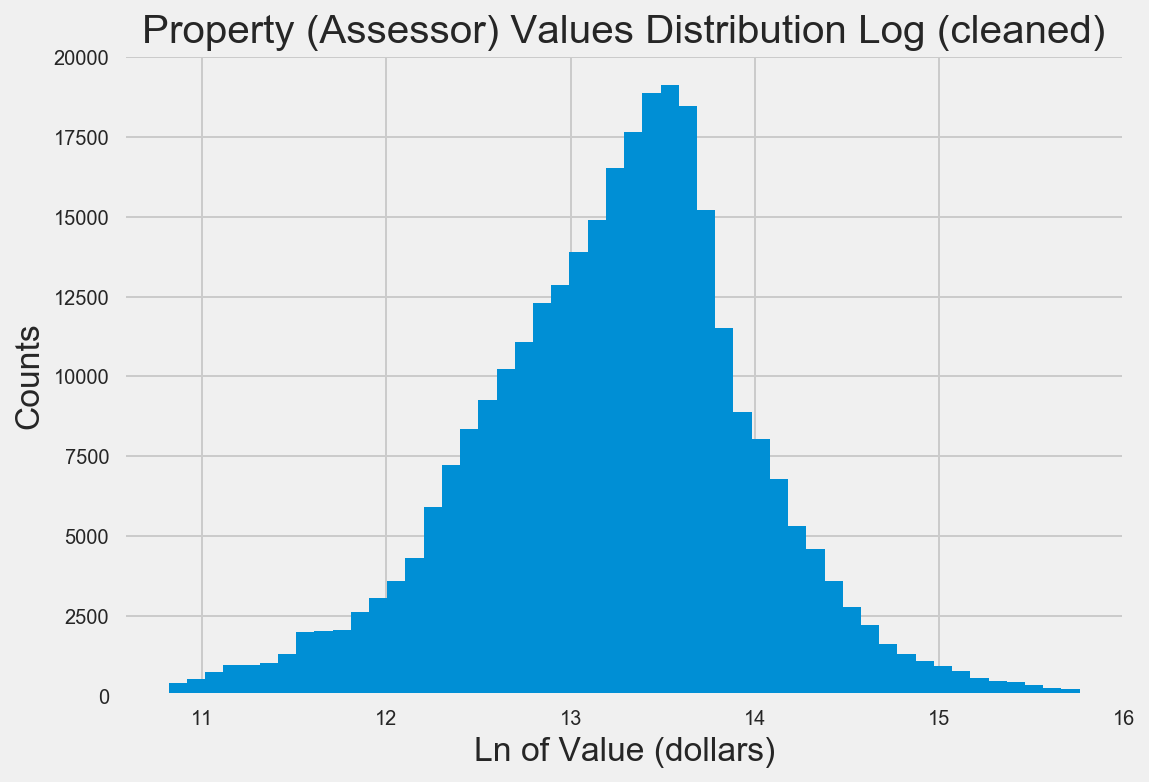

In [49]:
res_rolls_test.land_and_impro_val.apply(lambda x: np.log1p(x)).hist(bins=50)
plt.title('Property (Assessor) Values Distribution Log (cleaned)')
plt.xlabel('Ln of Value (dollars)')
plt.ylabel('Counts')
#plt.xlim((0, 4000000))
plt.savefig('ass_prop_value_dist_cleaned_log.pdf', facecolor='w')
plt.show();

Set desired search radius lengths for every category.

In [33]:
res_rolls_test = compile_model_data('crime and 311', res_rolls_test, short_311_cats, 
                                    short_crime_cats, crime_15up, rec_15up, 
                                    r_crime=0.003, r_311=0.003)
res_rolls_test.shape

(299072, 31)

In [34]:
res_rolls_test = find_neigh_cnt('park_reg_pts', park_reg_pts, res_rolls_test, r=0.004)


In [9]:
res_rolls_test = find_neigh_cnt('ldn_76', ldn_76, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_74', ldn_74, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_72', ldn_72, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_70', ldn_70, res_rolls_test, r=0.001)
res_rolls_test = find_neigh_cnt('ldn_66', ldn_66, res_rolls_test, r=0.001)

## Airbnb models (log_transform comparison)

In [10]:
# Predictors and target
# drop_cols = ['price_mod', 'price_y', 'price', 'latitude', 'longitude', 
#              'amenities']
drop_cols = ['id', 'id_x', 'price_mod', 'price_y', 'price', 'latitude', 'longitude', 
             'amenities', 'amenities_x', 'geometry', 'census_tract', 'listing_id']
keep_cols = [x for x in bnb_list_test.columns.values if x not in drop_cols]
X = bnb_list_test[keep_cols]

# ss = StandardScaler()
# Xs = ss.fit_transform(X)

y = bnb_list_test.price.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.3, random_state=101)


NameError: name 'bnb_list_test' is not defined

In [88]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

linreg.score(X_test, y_test)

94.269016407    9.70922326487
57.9851237464
39.787681173


0.60714354791969039

In [89]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

linregl.score(Xl_test, yl_test)

85.6028828733
46.1787757949
25.816212364


0.72916885145314381

In [90]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   11.111
Percent within 10 of price:  21.580
Percent within 20 of price:  42.132

Median error (percent):      24.609

Percent within 5 of price:   15.093
Percent within 10 of price:  28.966
Percent within 20 of price:  54.785

Median error (percent):      17.801


In [91]:
yl_pred_lr = yl_pred

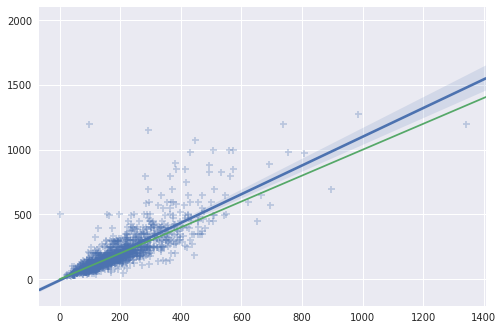

In [92]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

In [93]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=4, min_samples_split=4, 
                             min_samples_leaf=1, max_features= 'auto')
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

rfr.score(X_test, y_test)

85.2983617706
47.4580316357
26.0844158009


0.6783546188963484

In [94]:
rfrl = RandomForestRegressor(n_estimators=500, n_jobs=4, min_samples_split=4, 
                             min_samples_leaf=1, max_features= 'auto')
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)

print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

rfrl.score(Xl_test, yl_test)

84.7770079729
44.9931480167
23.0915744309


0.79088755665060784

In [95]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   17.405
Percent within 10 of price:  32.755
Percent within 20 of price:  56.455

Median error (percent):      16.767

Percent within 5 of price:   18.882
Percent within 10 of price:  34.682
Percent within 20 of price:  59.345

Median error (percent):      15.569


In [96]:
yl_pred_rfr = yl_pred

In [272]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (2, 3), 
          'min_samples_leaf': (1, 2), 
          'max_features': ('auto', 'sqrt')}
          #'oob_score': (False, True)}

rfrl = RandomForestRegressor(n_jobs=6)
gs_rfrl = GridSearchCV(rfrl, params, verbose=1)
gs_rfrl.fit(Xl_train, yl_train)
gs_rfrl.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  5.2min finished


{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

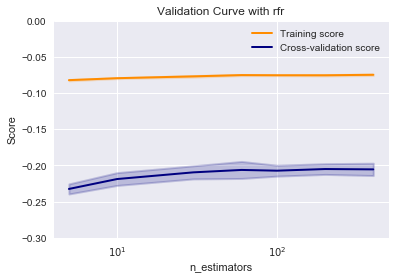

In [35]:
param_range = np.array([5, 10, 30, 60, 100, 200, 400])
rfrl = RandomForestRegressor(n_jobs=4)#min_samples_split=2, min_samples_leaf=1) n_estimators=300

train_scores, test_scores = validation_curve(rfrl, X, yl, param_name='n_estimators', 
                                             param_range=param_range, cv=5, 
                                             scoring="neg_median_absolute_error")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with rfr")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(-0.3, 0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

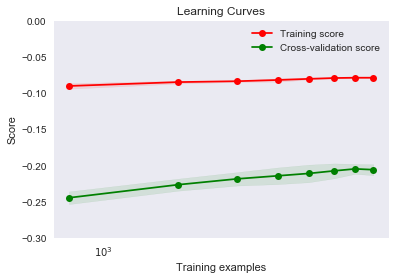

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 8)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="neg_median_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.semilogx(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.semilogx(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rfrl = RandomForestRegressor(n_estimators=200, min_samples_split=4, min_samples_leaf=2)#min_samples_split=2, min_samples_leaf=1) n_estimators=300
title = "Learning Curves"
cv = ShuffleSplit(n_splits=8, random_state=100)
plot_learning_curve(rfrl, title, X, yl, (0.1, 1.01), cv=cv, n_jobs=4)
plt.ylim((-0.3,0))
plt.show()

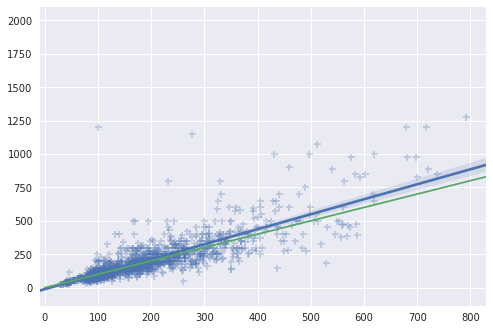

In [97]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

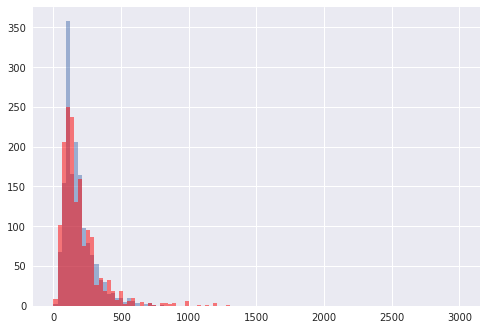

In [98]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,3000, num=100), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,3000, num=100), alpha=0.5, color='r');

In [99]:
bnb_list_test.shape

(5187, 114)

In [100]:
xgb = XGBRegressor(learning_rate= 0.02, max_depth= 3, n_estimators= 1000, 
                   reg_lambda= 1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

xgb.score(X_test, y_test)

80.6452674292    8.9802710109
46.0704628143
26.0688323975


0.7124894989069207

In [101]:
xgbl = XGBRegressor(learning_rate= 0.02, max_depth= 3, n_estimators= 1000, 
                    reg_lambda= 1)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

xgbl.score(Xl_test, yl_test)

78.1738710122
41.2560244421
22.4256210327


0.81399343273241609

In [102]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   15.157
Percent within 10 of price:  30.122
Percent within 20 of price:  53.243

Median error (percent):      18.447

Percent within 5 of price:   17.855
Percent within 10 of price:  34.618
Percent within 20 of price:  60.437

Median error (percent):      15.422


In [103]:
yl_pred_xgb = yl_pred

In [271]:
params = {'n_estimators':(800, 1000, 1200), 
          'learning_rate': (0.01, 0.02, 0.03), 
          'reg_lambda': (2, 5, 8), 
          'max_depth': (3, 4, 5)}

xgbl = XGBRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=4, verbose=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed: 13.1min finished


{'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 1000, 'reg_lambda': 2}

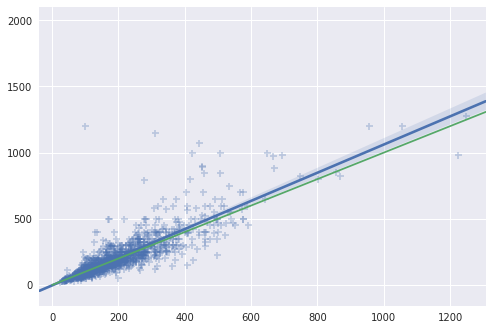

In [104]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

In [117]:
gbr = GradientBoostingRegressor(max_depth= 3, max_features= 'sqrt', min_samples_leaf= 3,
                                 min_samples_split= 5, n_estimators= 300)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

gbr.score(X_test, y_test)

81.7844677361
47.1599559658
27.7119623225


0.70430934324160965

In [118]:
gbrl = GradientBoostingRegressor(max_depth= 3, max_features= 'sqrt', min_samples_leaf= 3,
                                 min_samples_split= 5, n_estimators= 400)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(yl_pred, yl_test), '  ', np.sqrt(rmse(yl_pred, yl_test))
print mae(yl_pred, yl_test)
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

gbrl.score(Xl_test, yl_test)

0.279991341869    0.529142080985
0.203763727775
23.0612867609


0.80799765199550933

In [119]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   15.992
Percent within 10 of price:  28.838
Percent within 20 of price:  53.436

Median error (percent):      18.804

Percent within 5 of price:   17.983
Percent within 10 of price:  34.746
Percent within 20 of price:  60.822

Median error (percent):      15.347


In [120]:
yl_pred_gbr = yl_pred

In [270]:
params = {'n_estimators':(200, 300, 400), 
          'min_samples_split': (5, 6, 7), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (3, 4, 5), 
          'max_features': ('auto', 'sqrt')}

xgbl = GradientBoostingRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=4, verbose=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done 486 out of 486 | elapsed:  4.6min finished


{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 200}

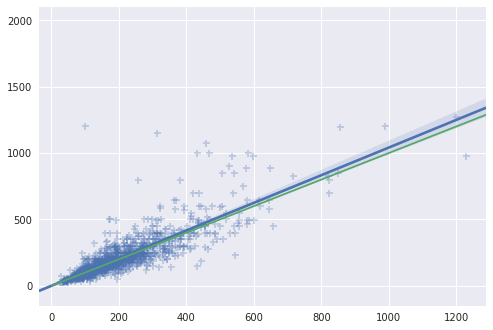

In [108]:
## sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

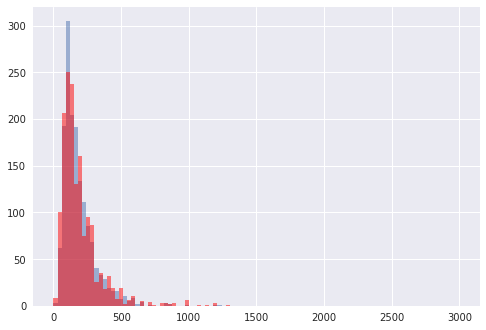

In [109]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,3000, num=100), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,3000, num=100), alpha=0.5, color='r');

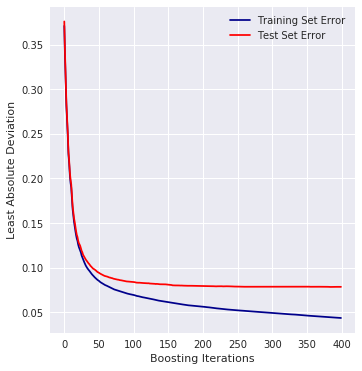

In [110]:
# plot error for each round of boosting
n_est = 400
test_score = np.zeros(n_est, dtype=np.float64)

train_score = gbrl.train_score_
for i, yl_pred in enumerate(gbrl.staged_predict(Xl_test)):
    test_score[i] = gbrl.loss_(yl_test, yl_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

In [111]:
pd.to_pickle(Xl_train, 'X_train')
pd.to_pickle(yl_train, 'y_train')
pd.to_pickle(Xl_test, 'X_test')
pd.to_pickle(yl_test, 'y_test')
pd.to_pickle(yl_pred_xgb, 'y_pred')
pd.to_pickle(bnb_list_test['id'], 'idx_id')
pd.to_pickle(bnb_list_test, 'bnb_list_test')

In [112]:
etr = ExtraTreesRegressor(n_jobs=4, n_estimators=400, bootstrap=True, 
                          min_samples_split=3, min_samples_leaf=1)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)

etr.score(X_test, y_test)

84.0005700938    9.16518249102
46.1984257541
25.6141071429


0.6880676580938716

In [113]:
etrl = ExtraTreesRegressor(n_jobs=4, bootstrap=True, max_depth= 4,
                           min_samples_leaf= 3, min_samples_split= 3, 
                           n_estimators= 300, oob_score= True)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred))

etrl.score(Xl_test, yl_test)


99.2072621834
53.446241231
29.7998126432


0.71511180966073784

In [114]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   17.662
Percent within 10 of price:  33.141
Percent within 20 of price:  57.033

Median error (percent):      16.700

Percent within 5 of price:   13.295
Percent within 10 of price:  25.562
Percent within 20 of price:  48.234

Median error (percent):      20.816


In [115]:
yl_pred_etr = yl_pred

In [269]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (5, 6, 7), 
          'min_samples_leaf': (1, 2), 
          'max_depth': (3, 4, 5), 
          'max_features': ('auto', 'sqrt')}

xtrl = ExtraTreesRegressor(bootstrap=True)
gs_xtrl = GridSearchCV(xtrl, params, n_jobs=6, verbose=1)
gs_xtrl.fit(Xl_train, yl_train)
gs_xtrl.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   25.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 324 out of 324 | elapsed:  3.5min finished


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 400}

In [127]:
yl_pred_mean = (yl_pred_gbr + yl_pred_xgb)/2.

In [128]:
yl_pred_mean

array([ 4.74584298,  5.59347918,  4.52519184, ...,  5.424117  ,
        5.53235138,  6.0470794 ])

In [129]:
print 'mae (sklearn): {}'.format(median_absolute_error(np.expm1(yl_test), np.expm1(yl_pred_mean)))
print
print_percents_log(yl_pred_mean, yl_test)

mae (sklearn): 21.7462505478

Percent within 5 of price:   19.011
Percent within 10 of price:  34.489
Percent within 20 of price:  61.785

Median error (percent):      15.035


## Property (tax roll) models (log_transform comparison)

In [11]:
# Predictors and target

drop_cols = ['latitude', 'longitude', 'land_and_impro_val', 'geometry', 'census_tract']
keep_cols = [x for x in res_rolls_test.columns.values if x not in drop_cols]
X = res_rolls_test[keep_cols]

ss = StandardScaler()
Xs = ss.fit_transform(X)

y = res_rolls_test.land_and_impro_val.values
yl = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X, yl, test_size=0.25, random_state=100)


In [12]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)

linreg.score(X_test, y_test)

576393.034715    759.205528639
362306.304532


0.1908643993094763

In [13]:
linregl = LinearRegression()
linregl.fit(Xl_train, yl_train)
yl_pred = linregl.predict(Xl_test)
print rmse(yl_pred, yl_test), '  ', np.sqrt(rmse(yl_pred, yl_test))
print mae(yl_pred, yl_test)

linregl.score(Xl_test, yl_test)

0.647202852411    0.804489187255
0.508789706339


0.14668848794205291

In [14]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   6.572
Percent within 10 of price:  13.049
Percent within 20 of price:  25.980

Median error (percent):      40.462

Percent within 5 of price:   5.687
Percent within 10 of price:  11.562
Percent within 20 of price:  23.626

Median error (percent):      39.541


In [15]:
rfr = RandomForestRegressor(n_estimators=600, n_jobs=3, 
                            min_samples_split=3, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
rfr.score(X_test, y_test)

249103.347129
115946.348212
45844.9893115


0.84887267756349893

In [16]:
rfrl = RandomForestRegressor(n_estimators=600, n_jobs=3, 
                             min_samples_split=3, min_samples_leaf=1)
rfrl.fit(Xl_train, yl_train)
yl_pred = rfrl.predict(Xl_test)

print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

rfrl.score(Xl_test, yl_test)

262622.371503
117833.178142
40757.5771182


0.84107041310960362

In [17]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   37.764
Percent within 10 of price:  57.261
Percent within 20 of price:  74.907

Median error (percent):      7.647

Percent within 5 of price:   39.949
Percent within 10 of price:  59.703
Percent within 20 of price:  76.792

Median error (percent):      6.955


In [32]:
params = {'n_estimators': (600, 700, 800),
          'min_samples_split': (3, 4, 5),
          'min_samples_leaf': (1, 2)}

rfrl = RandomForestRegressor(n_jobs=-1)
gs_rfrl = GridSearchCV(rfrl, params, verbose=6, pre_dispatch=1)
gs_rfrl.fit(Xl_train, yl_train)
gs_rfrl.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.803721, total=  58.5s
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.811735, total=  59.6s
[CV] min_samples_split=3, n_estimators=600, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=600, min_samples_leaf=1, score=0.805012, total=  59.2s
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.803998, total= 1.1min
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.811721, total= 1.2min
[CV] min_samples_split=3, n_estimators=700, min_samples_leaf=1 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


[CV]  min_samples_split=3, n_estimators=700, min_samples_leaf=1, score=0.804545, total= 1.2min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.803797, total= 1.3min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.811799, total= 1.3min
[CV] min_samples_split=3, n_estimators=800, min_samples_leaf=1 .......
[CV]  min_samples_split=3, n_estimators=800, min_samples_leaf=1, score=0.804532, total= 1.3min
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=4, n_estimators=600, min_samples_leaf=1, score=0.801830, total=  57.9s
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]  min_samples_split=4, n_estimators=600, min_samples_leaf=1, score=0.809495, total=  57.8s
[CV] min_samples_split=4, n_estimators=600, min_samples_leaf=1 .......
[CV]

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 61.9min finished


{'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}

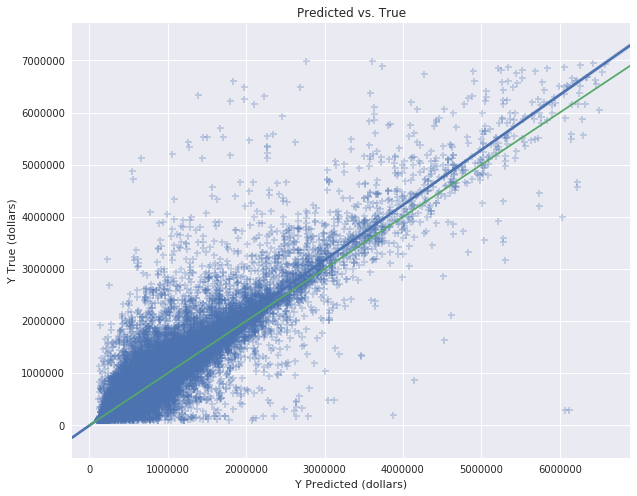

In [36]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
plt.figure(figsize=(10,8))
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,7000000), range(0,7000000))
plt.xlabel('Y Predicted (dollars)')
plt.ylabel('Y True (dollars)')
plt.title('Predicted vs. True')
plt.show();
# plt.xlim((0,3000))
# plt.ylim((0,3000));

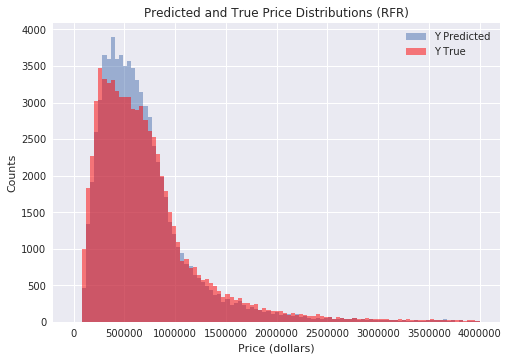

In [45]:
# plt.hist(yl_pred, bins=np.linspace(10,20, num=80), alpha=0.5)
# plt.hist(yl_test, bins=np.linspace(10,20, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=100), alpha=0.5, label='Y Predicted')
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=100), alpha=0.5, color='r', label='Y True');
plt.title('Predicted and True Price Distributions (RFR)')
plt.xlabel('Price (dollars)')
plt.ylabel('Counts')
plt.legend()
plt.savefig('ass_best_pred_true_dist_rfr')
plt.show();

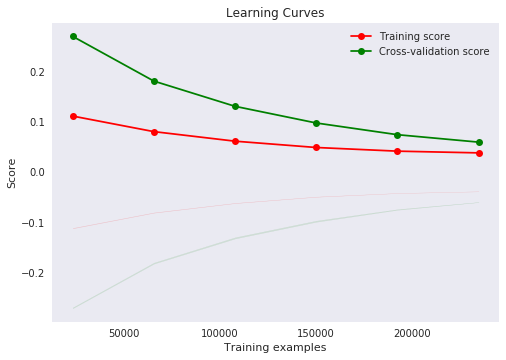

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring="neg_median_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, np.abs(train_scores_mean), 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, np.abs(test_scores_mean), 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

rfrl = RandomForestRegressor(n_estimators=600, n_jobs=-1, 
                             min_samples_split=3, min_samples_leaf=1)
title = "Learning Curves"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=100)
plot_learning_curve(rfrl, title, X, yl, (0.2, 1.01), cv=cv)
plt.ylim((0,0.4))
plt.savefig('ass_best_rfr_median_ae_LC.pdf')
plt.show()

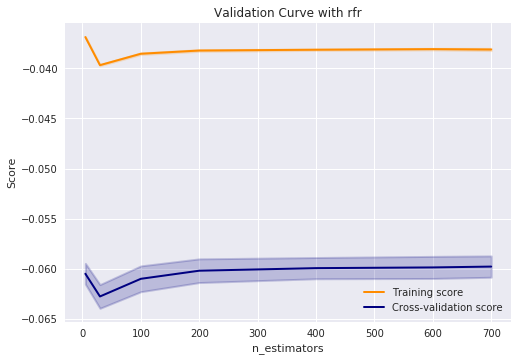

In [35]:
param_range = np.array([5, 30, 100, 200, 400, 600, 700])
rfrl = RandomForestRegressor(n_estimators=600, n_jobs=-1, 
                             min_samples_split=3, min_samples_leaf=1)

train_scores, test_scores = validation_curve(rfrl, X, yl, param_name='n_estimators', 
                                             param_range=param_range, cv=5, 
                                             scoring="neg_median_absolute_error")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with rfr")
plt.xlabel("n_estimators")
plt.ylabel("Score")
#plt.ylim(0.4, 1.0)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.savefig('ass_best_rfr_median_ae_VC.pdf')
plt.show()

In [75]:
etr = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True,
                           max_depth=5, min_samples_leaf=3, 
                           min_samples_split= 6)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))

etr.score(X_test, y_test)

520295.197656    721.314908799
338136.519662
38022.0738491


0.35656725671709155

In [76]:
etrl = ExtraTreesRegressor(n_jobs=-1, n_estimators=400, bootstrap=True,
                           max_depth=5, min_samples_leaf=3, 
                           min_samples_split= 6)
etrl.fit(Xl_train, yl_train)
yl_pred = etrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
etrl.score(Xl_test, yl_test)


572189.147352
344328.563258
225591.85455


0.24246720860427862

In [77]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   7.065
Percent within 10 of price:  14.270
Percent within 20 of price:  28.667

Median error (percent):      36.717

Percent within 5 of price:   5.699
Percent within 10 of price:  11.302
Percent within 20 of price:  23.561

Median error (percent):      38.603


In [65]:
params = {'n_estimators':(300, 400, 500), 
          'min_samples_split': (4, 5, 6), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (3, 4, 5), 
          'max_features': ('auto', 'sqrt')}

xtrl = ExtraTreesRegressor(bootstrap=True, n_jobs=-1)
gs_xtrl = GridSearchCV(xtrl, params, verbose=6, pre_dispatch=1)
gs_xtrl.fit(Xl_train, yl_train)
gs_xtrl.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.178229, total=   2.4s
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.177212, total=   2.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.178403, total=   2.5s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.177025, total=   3.1s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.177518, total=   3.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_split=4, n_estimators=400, max_depth=3, min_samples_leaf=1, score=0.176258, total=   3.3s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.176864, total=   4.2s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.176846, total=   3.8s
[CV] max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=4, n_estimators=500, max_depth=3, min_samples_leaf=1, score=0.174554, total=   3.9s
[CV] max_features=auto, min_samples_split=5, n_estimators=300, max_depth=3, min_samples_leaf=1 
[CV]  max_features=auto, min_samples_split=5, n_estimators=300, max_depth=3, min_samples_leaf=1, score=0.180

[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed: 31.3min finished


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 400}

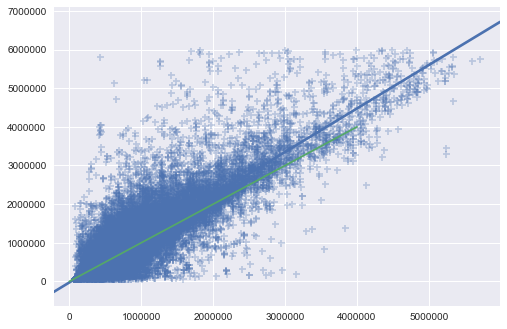

In [123]:
# sns.regplot(y_pred, y_test, marker='+', scatter_kws={'alpha':0.3})
sns.regplot(np.expm1(yl_pred), np.expm1(yl_test), marker='+', scatter_kws={'alpha':0.3})
plt.plot(range(0,4000000), range(0,4000000))
# plt.xlim((0,3000))
# plt.ylim((0,3000));

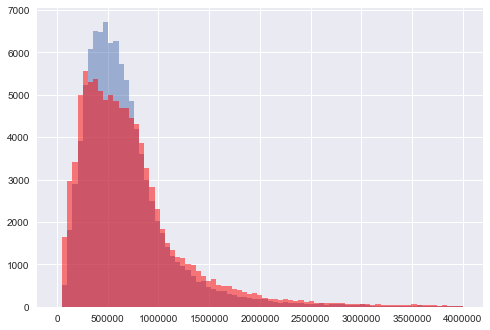

In [124]:
# plt.hist(y_pred, bins=np.linspace(0,1500, num=80), alpha=0.5)
# plt.hist(y_test, bins=np.linspace(0,1500, num=80), alpha=0.5, color='r');
plt.hist(np.expm1(yl_pred), bins=np.linspace(0,4000000, num=80), alpha=0.5)
plt.hist(np.expm1(yl_test), bins=np.linspace(0,4000000, num=80), alpha=0.5, color='r');

In [85]:
xgb = XGBRegressor(learning_rate = 0.08, max_depth = 5, 
                    n_estimators = 1000, reg_lambda = 0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
xgb.score(X_test, y_test)

363359.999801    602.793496814
247433.891526


0.68618206793582903

In [86]:
xgbl = XGBRegressor(learning_rate = 0.08, max_depth = 5, 
                    n_estimators = 1000, reg_lambda = 0.1)
xgbl.fit(Xl_train, yl_train)
yl_pred = xgbl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
xgbl.score(Xl_test, yl_test)

412783.235357
256057.80286


0.51980142828171116

In [87]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   9.403
Percent within 10 of price:  18.650
Percent within 20 of price:  36.941

Median error (percent):      27.952

Percent within 5 of price:   8.925
Percent within 10 of price:  17.650
Percent within 20 of price:  34.888

Median error (percent):      29.471


In [83]:
params = {'n_estimators':(800, 1000), 
          'learning_rate': (0.01, 0.02, 0.08), 
          'reg_lambda': (0.1, 2, 10), 
          'max_depth': (3, 4, 5)}

xgbl = XGBRegressor(nthread=-1)
gs_xgbl = GridSearchCV(xgbl, params, verbose=6, pre_dispatch=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.355963, total=   8.2s
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.353329, total=   8.0s
[CV] n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.9s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.349489, total=   8.1s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.3s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.356024, total=   8.1s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.8s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.352805, total=   8.2s
[CV] n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.3s remaining:    0.0s


[CV]  n_estimators=800, reg_lambda=2, learning_rate=0.01, max_depth=3, score=0.349013, total=   7.9s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.354119, total=   7.9s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.350768, total=   8.0s
[CV] n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=800, reg_lambda=10, learning_rate=0.01, max_depth=3, score=0.347619, total=   8.0s
[CV] n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.362462, total=   9.8s
[CV] n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3 
[CV]  n_estimators=1000, reg_lambda=0.1, learning_rate=0.01, max_depth=3, score=0.359924, total=   9.9s
[CV] n_estimators=1000, re

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 33.0min finished


{'learning_rate': 0.08,
 'max_depth': 5,
 'n_estimators': 1000,
 'reg_lambda': 0.1}

In [88]:
gbr = GradientBoostingRegressor(n_estimators=300)#, min_samples_split=7, min_samples_leaf=3)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
print median_absolute_error(y_test, y_pred)
gbr.score(X_test, y_test)

442429.105801    665.153445305
291074.356856


0.5347451567819641

In [90]:
gbrl = GradientBoostingRegressor(n_estimators=300)#, min_samples_split=7, min_samples_leaf=3)
gbrl.fit(Xl_train, yl_train)
yl_pred = gbrl.predict(Xl_test)
print rmse(np.expm1(yl_pred), np.expm1(yl_test))
print mae(np.expm1(yl_pred), np.expm1(yl_test))
print median_absolute_error(np.expm1(yl_pred), np.expm1(yl_test))
gbrl.score(Xl_test, yl_test)

474059.009327
294326.738933
192175.735411


0.39212345892769751

In [91]:
print_percents(y_pred, y_test)
print_percents_log(yl_pred, yl_test)

Percent within 5 of price:   8.156
Percent within 10 of price:  16.302
Percent within 20 of price:  32.252

Median error (percent):      31.763

Percent within 5 of price:   7.167
Percent within 10 of price:  14.579
Percent within 20 of price:  29.256

Median error (percent):      33.850


In [93]:
params = {'n_estimators':(300, 600), 
          'min_samples_split': (3, 4, 5), 
          'min_samples_leaf': (1, 2, 3), 
          'max_depth': (4, 5), 
          'max_features': ('auto', 'sqrt')}

xgbl = GradientBoostingRegressor()
gs_xgbl = GridSearchCV(xgbl, params, n_jobs=-1, verbose=6, pre_dispatch=1)
gs_xgbl.fit(Xl_train, yl_train)
gs_xgbl.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1 


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)


[CV]  max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1, score=0.422685, total= 1.8min
[CV] max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1 


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)


[CV]  max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1, score=0.419901, total= 1.7min
[CV] max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1 


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)


[CV]  max_features=auto, min_samples_split=3, n_estimators=300, max_depth=4, min_samples_leaf=1, score=0.419067, total= 1.8min
[CV] max_features=auto, min_samples_split=3, n_estimators=600, max_depth=4, min_samples_leaf=1 


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/gradient_boosting.py:96: FutureWarning: np.average currently does not preserve subclasses, but will do so in the future to match the behavior of most other numpy functions such as np.mean. In particular, this means calls which returned a scalar may return a 0-d subclass object instead.
  self.mean = np.average(y, weights=sample_weight)
Process PoolWorker-65:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
Process PoolWorker-64:
Traceback (most recent call last):
    task = get()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
    rac

KeyboardInterrupt: 

  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    task = get()
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
  File "/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


Plot error curves for different models. Both median error percentage and median absolute error on one plot. Another area plot for the percentage within x% groups for both the Airbnb and assessor data.

In [3]:
bnb_5 = [14.207, 13.658, 13.827, 13.615, 12.389, 15.992]
bnb_5_log = [16.744, 16.279, 15.729, 16.068, 15.982, 17.983]
bnb_10 = [27.357, 26.342, 27.273, 26.596, 25.666, 28.838]
bnb_10_log = [32.135, 31.712, 31.459, 31.459, 32.22, 34.746]
bnb_20 = [49.852, 49.049, 50.951, 48.33, 46.85, 53.436]
bnb_20_log = [56.279, 56.448, 56.871, 57.294, 57.04, 60.822]
bnb_mep = [20.049, 20.403, 19.604, 20.852, 21.529, 18.804]
bnb_mep_log = [16.783, 16.864, 17.011, 16.847, 16.749, 15.347]
bnb_mae = [30.48, 30.68, 28.23, 30.19, 31.92, 27.71]
bnb_mae_log = [24.8, 25.3, 25.48, 25.4, 25.74, 23.06]

ass_5 = [34.325, 37.618, 40.022, 40.386, 40.503, 40.43]
ass_5_log = [36.091, 39.235, 41.865, 42.499, 42.472, 42.554]
ass_10 = [52.783, 56.932, 59.786, 60.232, 60.355, 60.422]
ass_10_log = [54.701, 58.569, 61.546, 62.143, 62.221, 62.318]
ass_20 = [70.75, 74.305, 76.869, 77.14, 77.254, 77.214]
ass_20_log = [72.035, 75.511, 77.862, 78.154, 78.286, 78.356]
ass_mep = [8.98, 7.665, 6.94, 6.828, 6.766, 6.787]
ass_mep_log = [8.301, 7.165, 6.434, 6.31, 6.298, 6.284]
ass_mae = [54342, 46651, 41854, 41159, 41151, 41000]
ass_mae_log = [49886, 43325, 38456, 37624, 37426, 37394]

x_ticks = ['Baseline', '+ Income/Poverty', '+ Crime', '+ 311', '+ Parks/Noise', 'Best Tuned']

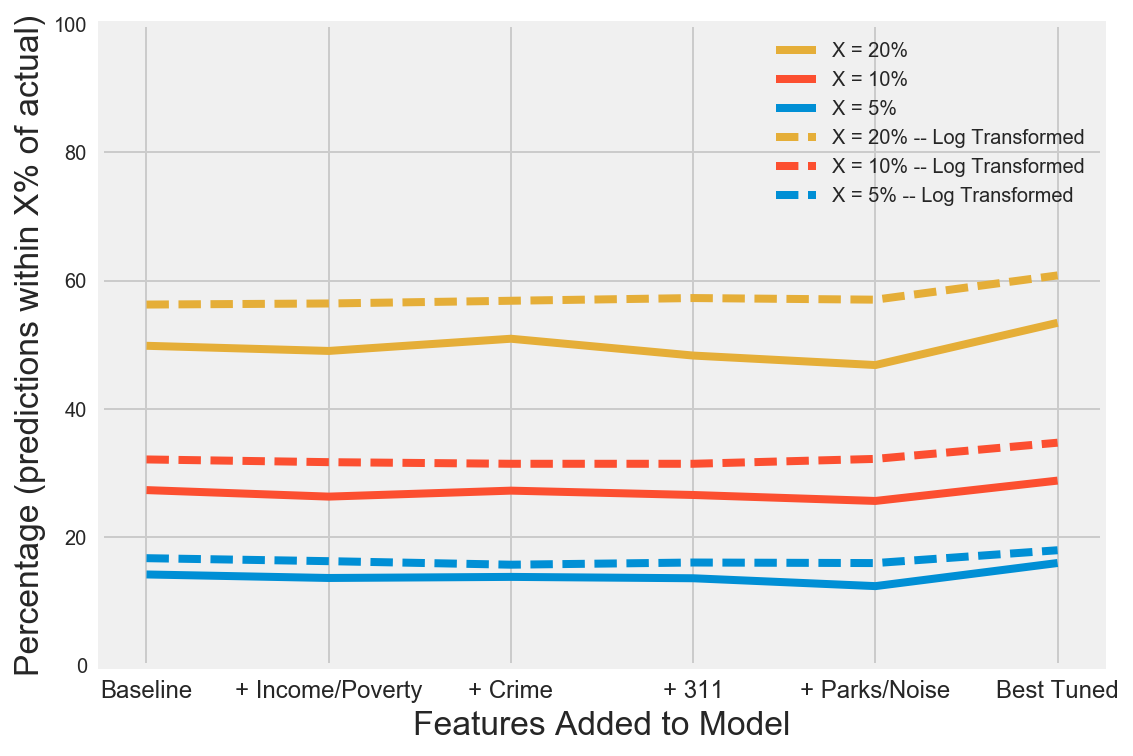

In [4]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_20, color=colors[2], label='X = 20%')
#plt.fill_between(range(6), bnb_20, color=colors[2])
plt.plot(bnb_10, color=colors[1], label='X = 10%')
#plt.fill_between(range(6), bnb_10, color=colors[1])
plt.plot(bnb_5, color=colors[0], label='X = 5%')
#plt.fill_between(range(6), bnb_5, color=colors[0])
plt.plot(bnb_20_log, '--', color=colors[2], label='X = 20% -- Log Transformed')
#plt.fill_between(range(6), bnb_20, color=colors[2])
plt.plot(bnb_10_log, '--', color=colors[1], label='X = 10% -- Log Transformed')
#plt.fill_between(range(6), bnb_10, color=colors[1])
plt.plot(bnb_5_log, '--', color=colors[0], label='X = 5% -- Log Transformed')
#plt.fill_between(range(6), bnb_5, color=colors[0])

plt.ylim(0,100)
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Percentage (predictions within X% of actual)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=10)
plt.savefig('bnb_percents_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()

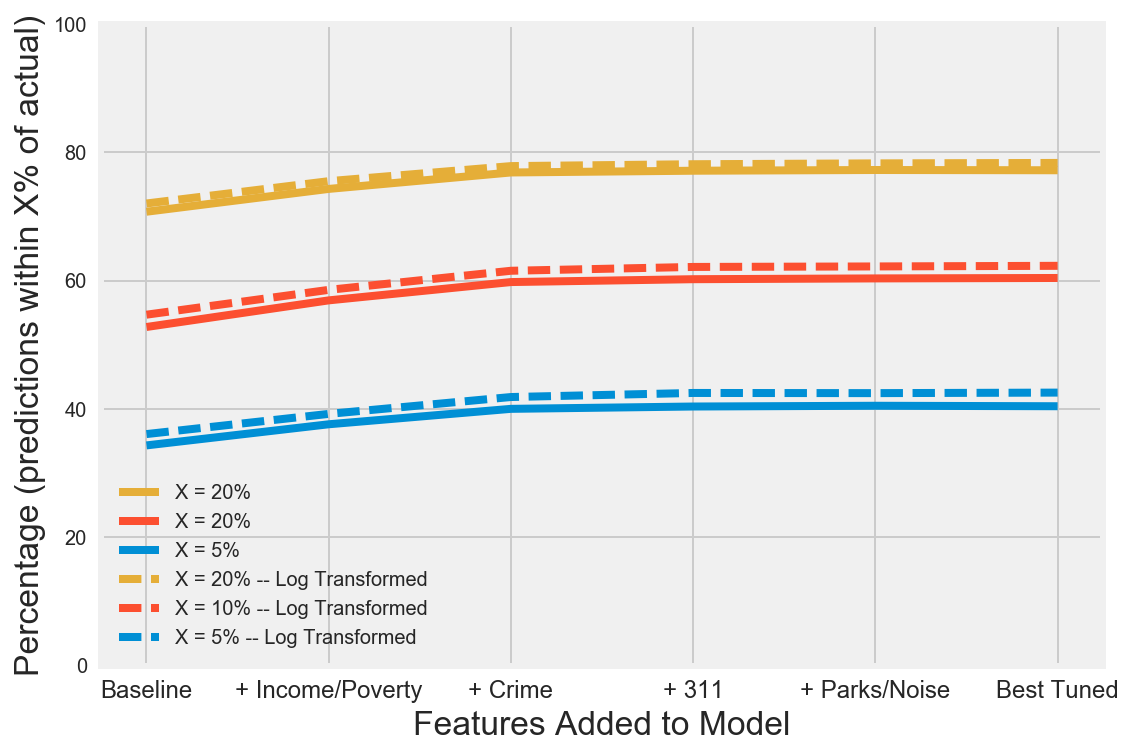

In [5]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_20, color=colors[2], label='X = 20%')
#plt.fill_between(range(6), ass_20, color=colors[2])
plt.plot(ass_10, color=colors[1], label='X = 20%')
#plt.fill_between(range(6), ass_10, color=colors[1])
plt.plot(ass_5, color=colors[0], label='X = 5%')
#plt.fill_between(range(6), ass_5, color=colors[0])
plt.plot(ass_20_log, '--', color=colors[2], label='X = 20% -- Log Transformed')
#plt.fill_between(range(6), ass_20, color=colors[2])
plt.plot(ass_10_log, '--', color=colors[1], label='X = 10% -- Log Transformed')
#plt.fill_between(range(6), ass_10, color=colors[1])
plt.plot(ass_5_log, '--', color=colors[0], label='X = 5% -- Log Transformed')
#plt.fill_between(range(6), ass_5, color=colors[0])

plt.ylim(0,100)
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Percentage (predictions within X% of actual)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=10)
plt.savefig('ass_percents_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show()

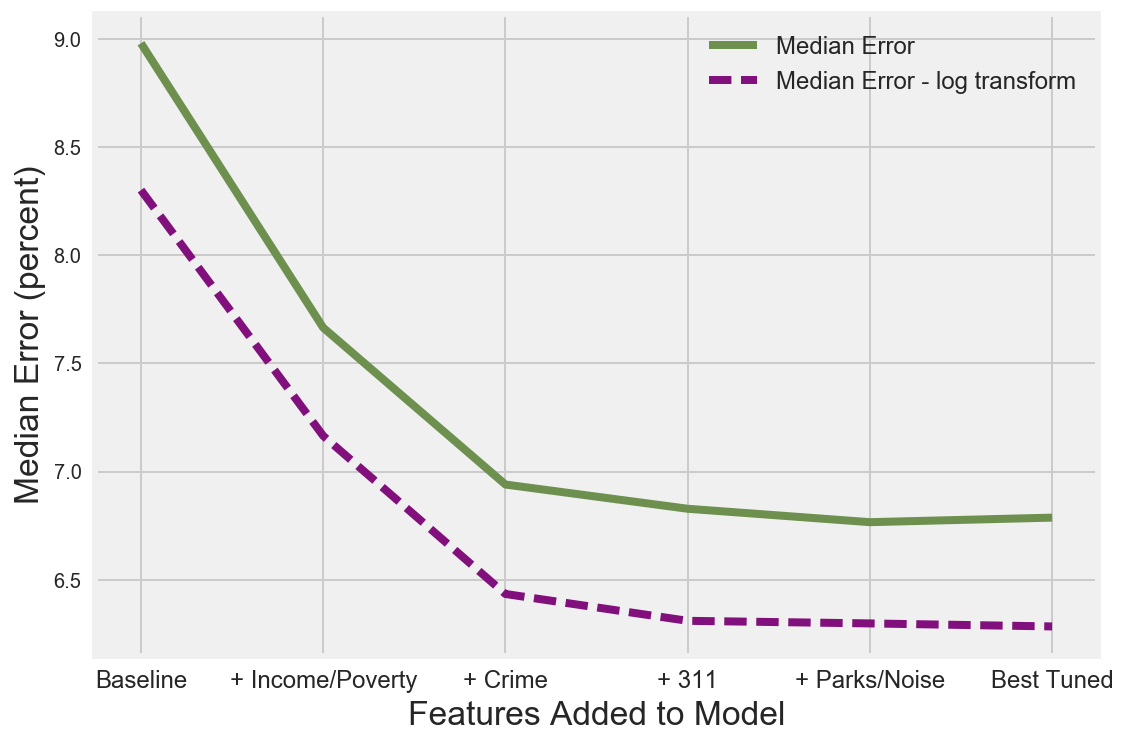

In [6]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_mep, color=colors[3], label='Median Error')
plt.plot(ass_mep_log, '--', color=colors[5], label='Median Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Error (percent)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
plt.savefig('ass_mep_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show;
#plt.ylim(5,10)

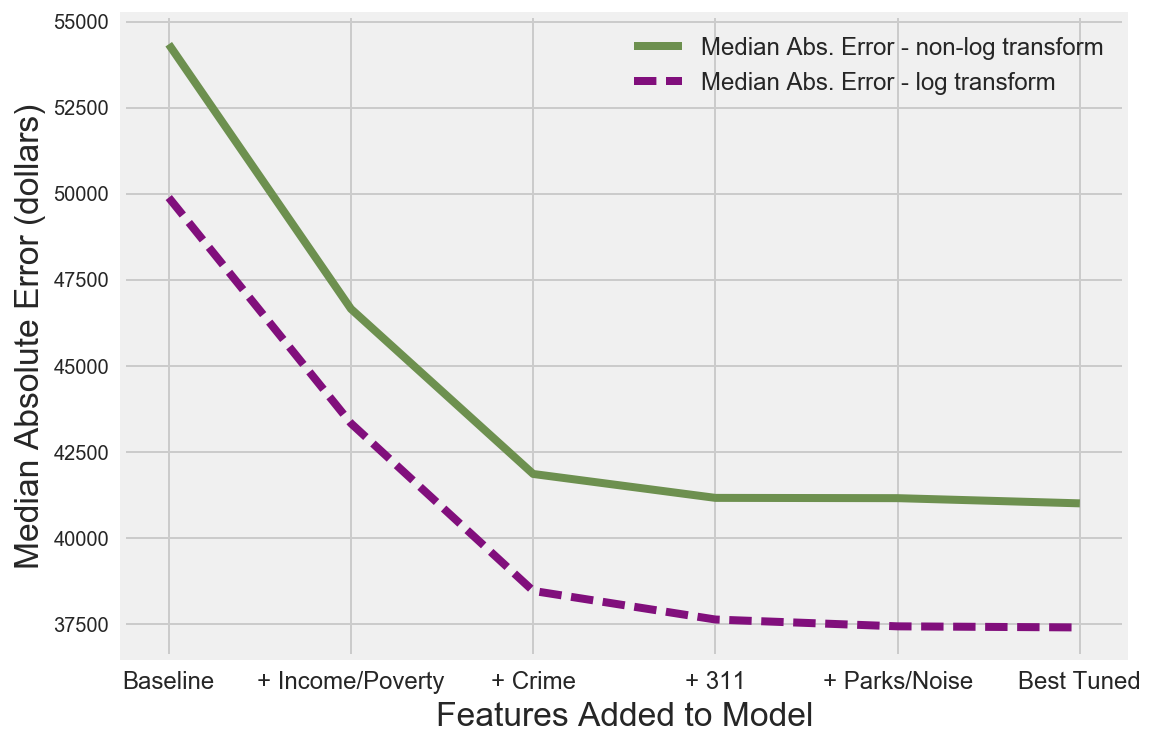

In [7]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(ass_mae, color=colors[3], label='Median Abs. Error - non-log transform')
plt.plot(ass_mae_log, '--', color=colors[5], label='Median Abs. Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Absolute Error (dollars)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
plt.savefig('ass_mae_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show;
#plt.ylim(5,10)

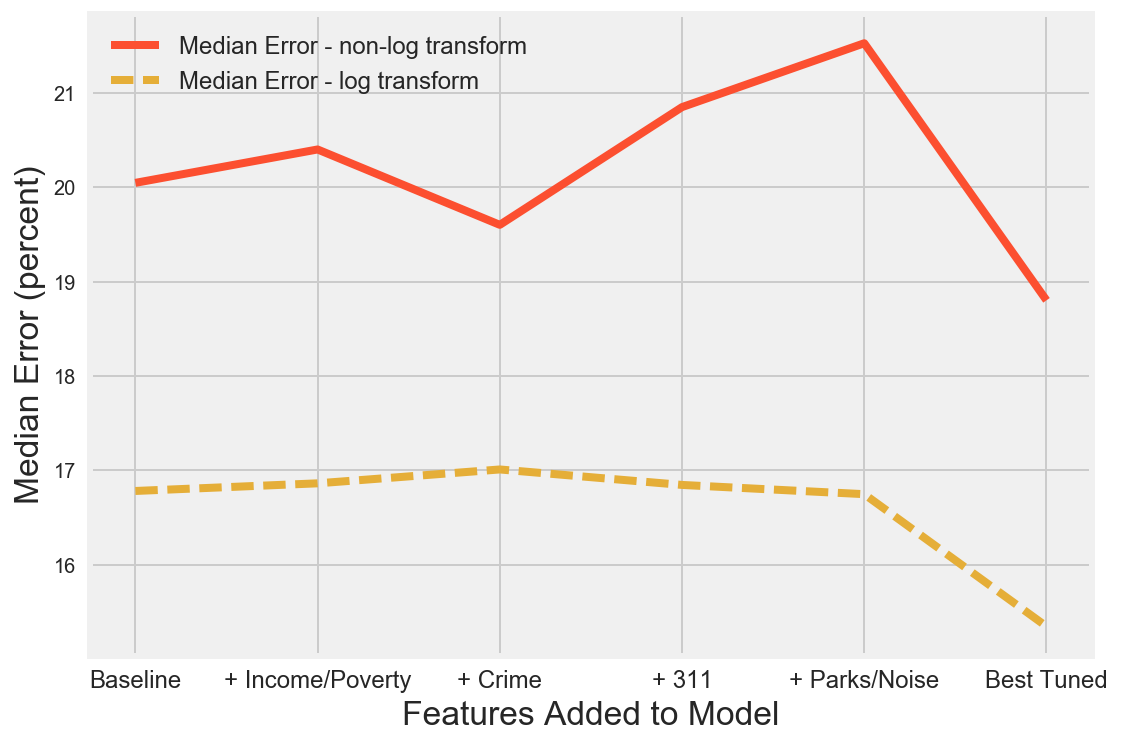

In [11]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_mep, color=colors[1], label='Median Error - non-log transform')
plt.plot(bnb_mep_log, '--', color=colors[2], label='Median Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Error (percent)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
plt.savefig('bnb_mep_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show;
#plt.ylim(5,10)

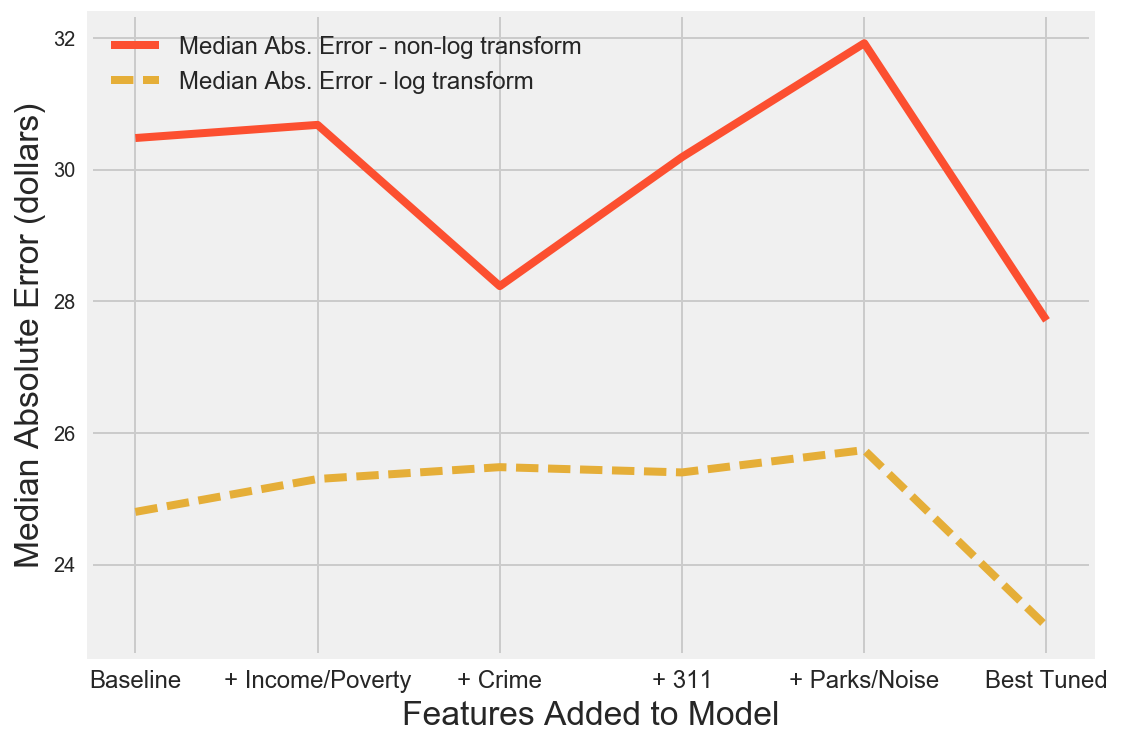

In [10]:
plt.figure(frameon=True, edgecolor='k', facecolor='w')
plt.plot(bnb_mae, color=colors[1], label='Median Abs. Error - non-log transform')
plt.plot(bnb_mae_log, '--', color=colors[2], label='Median Abs. Error - log transform')
plt.xticks(range(6), x_ticks, fontsize=12)
plt.ylabel('Median Absolute Error (dollars)')
plt.xlabel('Features Added to Model')
plt.legend(fontsize=12)
plt.savefig('bnb_mae_plot.png', facecolor='w', bbox_inches='tight', dpi=600)
plt.show;
#plt.ylim(5,10)